In [16]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt

from xgboost import XGBClassifier


# Necessary to get names out
SimpleImputer.get_feature_names_out = (lambda self, names=None:
                                       self.feature_names_in_)

In [17]:
features_num = [
    "Z_BEST", "z1_median", "u_f", "u_e", "u_e_raw", "g_f", "g_e", "g_e_raw", "r_f", "r_e", 
    "r_e_raw", "z_f", "z_e", "z_e_raw", "g_rcs_f", "g_rcs_e", "g_rcs_e_raw", "r_rcs_f", "r_rcs_e", 
    "r_rcs_e_raw", "i_rcs_f", "i_rcs_e", "i_rcs_e_raw", "z_rcs_f", "z_rcs_e", "z_rcs_e_raw", "J_f", 
    "J_e", "J_e_raw", "K_f", "K_e", "K_e_raw", "ch1_swire_f", "ch1_swire_e", "ch1_swire_e_raw", "ch2_swire_f",
    "ch2_swire_e", "ch2_swire_e_raw", "ch3_swire_f", "ch3_swire_e", "ch3_swire_e_raw", "ch4_swire_f", 
    "ch4_swire_e", "ch4_swire_e_raw", "ch1_servs_f", "ch1_servs_e", "ch1_servs_e_raw", "ch2_servs_f", 
    "ch2_servs_e", "ch2_servs_e_raw", "MIPS_24_f", "MIPS_24_e", "MIPS_24_e_raw", "PACS_100_f", "PACS_100_e", 
    "PACS_100_e_raw", "PACS_160_f", "PACS_160_e", "PACS_160_e_raw", "SPIRE_250_f", "SPIRE_250_e", "SPIRE_250_e_raw", 
    "SPIRE_350_f", "SPIRE_350_e", "SPIRE_350_e_raw", "SPIRE_500_f", "SPIRE_500_e", "SPIRE_500_e_raw"
]
features_cat_binary = [
    "FLAG_OVERLAP", "XID+_rerun_mips", "XID+_rerun_pacs", "XID+_rerun_SPIRE", "CHANGE_FLAG_ID", 
    "CHANGE_FLAG_ZBEST", "CHANGE_FLAG_DEEP", "CHANGE_FLAG_FIR", "FLAG_GOOD"
]
features_drop = [
    "Source_Name"
]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [18]:
# Creating the pipeline
transformer_num = make_pipeline(
    SimpleImputer(strategy="mean"),  # there are a few missing values
    StandardScaler(),
)
# Almost all cat features are already binary, so don't have to be one-hot encoded
transformer_cat_binary = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat_binary, features_cat_binary),
)

In [19]:
data = pd.read_csv("../../../Data/Fangyou_data/Cleaned/Lockman_clean.csv")

In [20]:
# Dropping required columns
X = data.drop(columns=features_drop)
X = X.drop(columns=y_column)
y = data[y_column]

In [21]:
# Transforming y to labels
le = preprocessing.LabelEncoder()
labels = np.unique(y)
y = le.fit_transform(y)

# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [22]:
# Transforming the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [23]:
# Class weights
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# PCA

In [24]:
pca = PCA().fit(X_train)

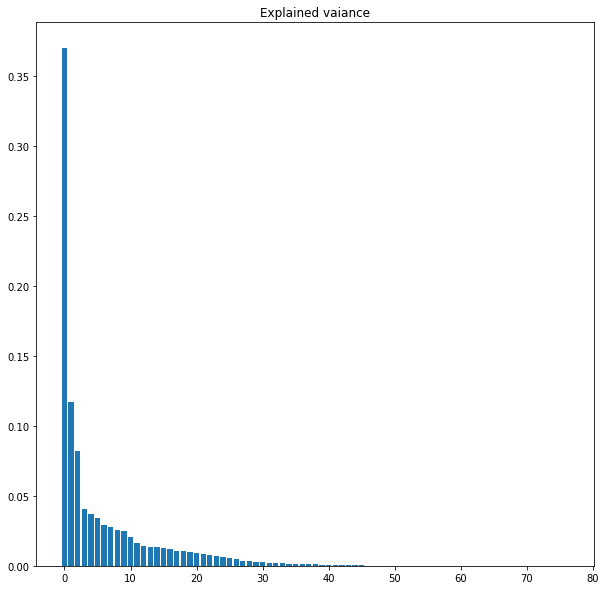

In [25]:
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10,10))
plt.bar(range(len(explained_variance)),explained_variance)
plt.title("Explained vaiance")
plt.show()

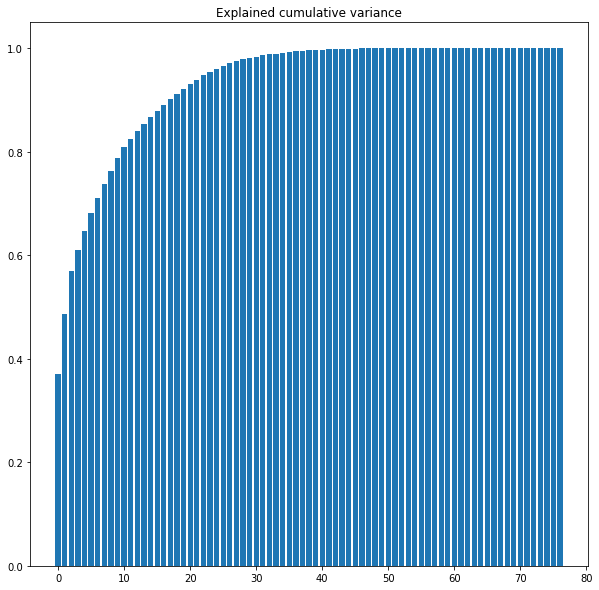

In [26]:
plt.figure(figsize=(10,10))
plt.bar(range(len(explained_variance)),explained_variance.cumsum())
plt.title("Explained cumulative variance")
plt.show()

# Random forest

In [27]:
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced")
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [28]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8368    0.4811    0.6110      1588
quasar-like radio AGN / high-excitation radio galaxy     0.4118    0.0400    0.0729       175
                                     radio-quiet AGN     0.7265    0.4602    0.5635       704
                                 star-forming galaxy     0.8295    0.9704    0.8945      6423

                                            accuracy                         0.8243      8890
                                           macro avg     0.7011    0.4879    0.5355      8890
                                        weighted avg     0.8144    0.8243    0.8014      8890



[]

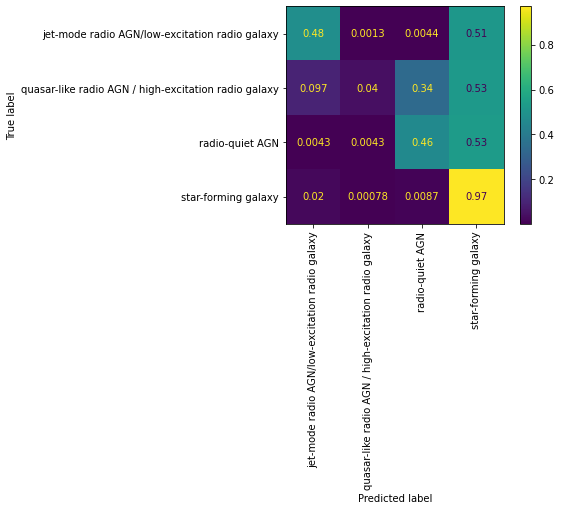

In [29]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

In [30]:
random_forest_feature_importance = pd.DataFrame(
    np.array([preprocessor.get_feature_names_out(), clf.feature_importances_]).T,
                                               columns=['Feature', 'Importance'])
random_forest_feature_importance = random_forest_feature_importance.sort_values(by=['Importance'], ascending=False)

[]

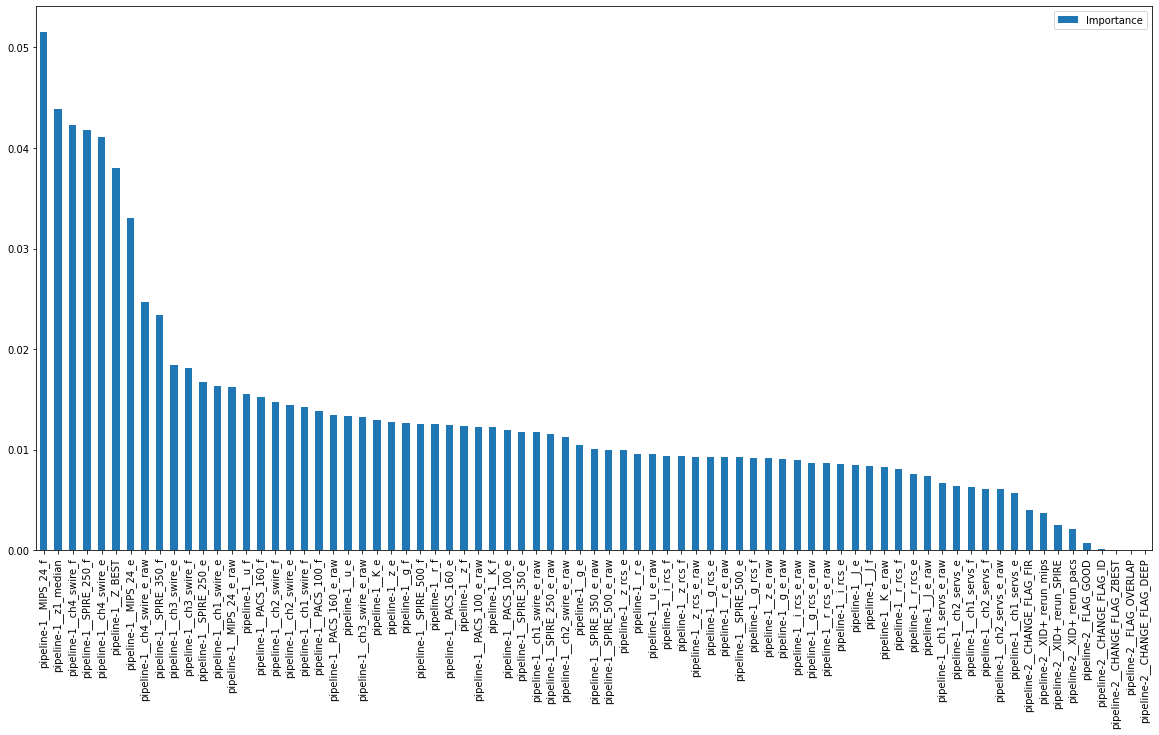

In [31]:
ax = random_forest_feature_importance.plot(kind='bar', figsize=(20,10))
ax.set_xticklabels(random_forest_feature_importance.Feature)
plt.plot()

## Hyperparameter tuning

In [32]:
# Metrics for hyperparameter tuning
metrics = {"Accuracy": "accuracy",
          "Balanced accuracy": "balanced_accuracy",
          "F1 score": "f1_weighted"}

In [19]:
# Parameter space
parameters = {"n_estimators": [10,20,50,100,150,200],
             "criterion": ["gini", "entropy"],
             "max_depth": [10,30,50,70],
             "min_samples_split": [2,10,20],
             }

In [20]:
random_forest = RandomForestClassifier()
clf = GridSearchCV(estimator=random_forest, 
                   param_grid=parameters,
                  scoring=metrics,
                  refit="Accuracy",
                  return_train_score=True,
                  n_jobs=-1,
                  cv=2,
                  verbose=4)

clf.fit(X_train, y_train)

Fitting 2 folds for each of 144 candidates, totalling 288 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 30, 50, 70],
                         'min_samples_split': [2, 10, 20],
                         'n_estimators': [10, 20, 50, 100, 150, 200]},
             refit='Accuracy', return_train_score=True,
             scoring={'Accuracy': 'accuracy',
                      'Balanced accuracy': 'balanced_accuracy',
                      'F1 score': 'f1_weighted'},
             verbose=4)

In [23]:
clf

GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 30, 50, 70],
                         'min_samples_split': [2, 10, 20],
                         'n_estimators': [10, 20, 50, 100, 150, 200]},
             refit='Accuracy', return_train_score=True,
             scoring={'Accuracy': 'accuracy',
                      'Balanced accuracy': 'balanced_accuracy',
                      'F1 score': 'f1_weighted'},
             verbose=4)

In [21]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8273    0.6064    0.6998       940
quasar-like radio AGN / high-excitation radio galaxy     0.0000    0.0000    0.0000       109
                                     radio-quiet AGN     0.7395    0.5051    0.6002       590
                                 star-forming galaxy     0.8343    0.9579    0.8918      3680

                                            accuracy                         0.8259      5319
                                           macro avg     0.6003    0.5173    0.5480      5319
                                        weighted avg     0.8055    0.8259    0.8073      5319



# XGboost

In [33]:
model = XGBClassifier(use_label_encoder=False, max_depth=7)
model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=True)

[20:01:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.05147
[1]	validation_0-mlogloss:0.86664
[2]	validation_0-mlogloss:0.74945
[3]	validation_0-mlogloss:0.66669
[4]	validation_0-mlogloss:0.60963
[5]	validation_0-mlogloss:0.56917
[6]	validation_0-mlogloss:0.53821
[7]	validation_0-mlogloss:0.51641
[8]	validation_0-mlogloss:0.49895
[9]	validation_0-mlogloss:0.48571
[10]	validation_0-mlogloss:0.47525
[11]	validation_0-mlogloss:0.46650
[12]	validation_0-mlogloss:0.45957
[13]	validation_0-mlogloss:0.45403
[14]	validation_0-mlogloss:0.44958
[15]	validation_0-mlogloss:0.44649
[16]	validation_0-mlogloss:0.44460
[17]	validation_0-mlogloss:0.44156
[18]	validation_0-mlogloss:0.44001
[19]	validation_0-mlogloss:0.43832

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [35]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8059    0.5724    0.6694      1588
quasar-like radio AGN / high-excitation radio galaxy     0.3939    0.0743    0.1250       175
                                     radio-quiet AGN     0.6736    0.6449    0.6589       704
                                 star-forming galaxy     0.8670    0.9524    0.9077      6423

                                            accuracy                         0.8429      8890
                                           macro avg     0.6851    0.5610    0.5902      8890
                                        weighted avg     0.8315    0.8429    0.8300      8890



[]

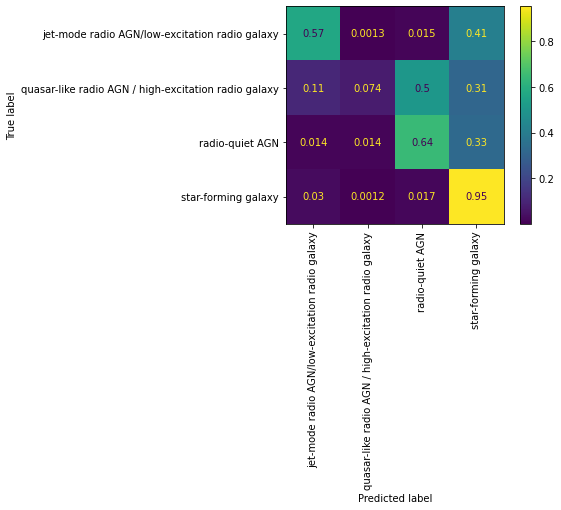

In [36]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# SVM

In [49]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [50]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8596    0.4558    0.5957      1007
quasar-like radio AGN / high-excitation radio galaxy     0.0000    0.0000    0.0000       123
                                     radio-quiet AGN     0.7860    0.2960    0.4300       571
                                 star-forming galaxy     0.7768    0.9812    0.8671      3618

                                            accuracy                         0.7855      5319
                                           macro avg     0.6056    0.4332    0.4732      5319
                                        weighted avg     0.7755    0.7855    0.7488      5319



d:\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
